In [3]:
import re
import os
import json
import pickle
import numpy as np
from typing import Dict, Any, List, Literal
from dataclasses import dataclass
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from openai import OpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [4]:
# State definition for LangGraph
class CustomerServiceState(TypedDict):
    messages: List[Dict[str, str]]
    query: str
    route: str
    response: str
    routing_method: str


@dataclass
class RoutingResult:
    route: Literal["order_status", "product_info", "technical_support","billing","general"]
    confidence: float
    method: str

In [5]:
class CustomerServiceRouter:
    """Main router class containing all routing methods"""
    
    def __init__(self):
        pass

    def llm_based_routing(self, query: str) -> RoutingResult:
        """Route using LLM analysis"""
        prompt = f"""
        Analyze the following customer service query and classify it into exactly one category.
        
        Query: "{query}"
        
        Categories:
        - order_status: Questions about order tracking, delivery, shipping status
        - product_info: Questions about product specifications, availability, features
        - technical_support: Technical issues, troubleshooting, bugs, problems
        - billing: Payment, refund, billing, invoice questions
        - general: General questions or anything that doesn't fit other categories
        
        Respond JSON format: {{"route": "", "confidence": 1, "method": "llm"}}
        """
        client = OpenAI()
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies customer service queries."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=50,
            temperature=0
        )
        
        # Parse the response content as JSON
        response_content = response.choices[0].message.content
        response_data = json.loads(response_content)
        
        # Validate and return the Pydantic model
        return RoutingResult(**response_data)
       
    
    def embedding_based_routing(self, query: str) -> RoutingResult:
        """Route using embedding similarity"""
        def get_openai_embedding(text: str) -> np.ndarray:
            client = OpenAI()
            response = client.embeddings.create(
                input=text,
                model="text-embedding-3-small"
            )
            return np.array(response.data[0].embedding)

        query_embedding = get_openai_embedding(query)
        
        best_route = None
        best_similarity = -1

        route_descriptions = {
        "order_status": "track order delivery shipping status when will my order arrive",
        "product_info": "product specifications features availability price catalog information",
        "technical_support": "troubleshooting technical issues bugs problems not working",
        "billing": "payment refund billing invoice charge credit card money",
        "general": "general questions help information other inquiries"
        }
        
        route_embeddings = {route: get_openai_embedding(desc) for route, desc in route_descriptions.items()}
        
        for route, embedding in route_embeddings.items():
            similarity = np.dot(query_embedding, embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(embedding))
            if similarity > best_similarity:
                best_similarity = similarity
                best_route = route
        
        return RoutingResult(route=best_route, confidence=float(best_similarity), method="embedding")

    def rule_based_routing(self, query: str) -> RoutingResult:
        """Route using predefined rules and keyword matching"""
        query_lower = query.lower()
        
        # Define routing rules
        rules = {
            "order_status": [
                r'\border\b',
                r'\btrack\b',
                r'\bdelivery\b',
                r'\bshipping\b',
                r'\bwhen.*arrive\b',
                r'\bstatus\b',
                r'\bpackage\b'
            ],
            "product_info": [
                r'\bproduct\b',
                r'\bspecs?\b',
                r'\bspecifications?\b',
                r'\bfeatures?\b',
                r'\bavailable\b',
                r'\bprice\b',
                r'\bcost\b',
                r'\bitem\b'
            ],
            "technical_support": [
                r'\btechnical\b',
                r'\bbug\b',
                r'\berror\b',
                r'\bfix\b',
                r'\btroubleshoot\b',
                r'\bnot working\b',
                r'\bissue\b',
                r'\bproblem\b'
            ],
            "billing": [
                r'\bbilling\b',
                r'\bpayment\b',
                r'\brefund\b',
                r'\bcharge\b',
                r'\binvoice\b',
                r'\bmoney\b',
                r'\bcredit card\b',
                r'\bcard\b'
            ]
        }
        
        # Check rules for each category
        route_scores = {}
        for route, patterns in rules.items():
            score = sum(1 for pattern in patterns if re.search(pattern, query_lower))
            if score > 0:
                route_scores[route] = score
        
        if route_scores:
            best_route = max(route_scores, key=route_scores.get)
            # Normalize confidence based on matches
            confidence = min(route_scores[best_route] / 3, 1.0)
        else:
            best_route = "general"
            confidence = 0.5
        
        return RoutingResult(route=best_route, confidence=confidence, method="rule")

    

    def ml_based_routing(self,query: str) -> RoutingResult:
            """Route using trained ML classifier loaded from pickle file"""

            def load_ml_classifier(model_path: str = "customer_service_classifier.pkl") -> Pipeline:
                """Load ML classifier from pickle file or create and save new one"""
                model_path = "customer_service_classifier.pkl"
                
                if os.path.exists(model_path):                    
                    with open(model_path, 'rb') as f:
                        return pickle.load(f)
                else:
                    raise FileNotFoundError(f"{model_path} not found. Please train the model first.")

            ml_classifier = load_ml_classifier()

            # Predict using the loaded classifier
            prediction = ml_classifier.predict([query])[0]
            
            # Get prediction probabilities for confidence
            probabilities = ml_classifier.predict_proba([query])[0]
            confidence = float(max(probabilities))
            
            return RoutingResult(route=prediction, confidence=confidence, method="ml")

In [6]:
# Route handler functions
def handle_order_status(state: CustomerServiceState) -> CustomerServiceState:
    """Handle order status inquiries"""
    response = f"I'll help you track your order. Let me look up the status for you..."
    state["response"] = response
    return state


def handle_product_info(state: CustomerServiceState) -> CustomerServiceState:
    """Handle product information requests"""
    response = f"I'll provide you with detailed product information..."
    state["response"] = response
    return state


def handle_technical_support(state: CustomerServiceState) -> CustomerServiceState:
    """Handle technical support issues"""
    response = f"I understand you're experiencing technical difficulties. Let me help troubleshoot..."
    state["response"] = response
    return state


def handle_billing(state: CustomerServiceState) -> CustomerServiceState:
    """Handle billing inquiries"""
    response = f"I'll assist you with your billing inquiry. Let me review your account..."
    state["response"] = response
    return state


def handle_general(state: CustomerServiceState) -> CustomerServiceState:
    """Handle general inquiries"""
    response = f"Thank you for your inquiry. I'm here to help with any questions you may have..."
    state["response"] = response
    return state


In [7]:
# Router node functions for LangGraph
router = CustomerServiceRouter()

def llm_router_node(state: CustomerServiceState) -> CustomerServiceState:
    """LLM-based routing node"""
    result = router.llm_based_routing(state["query"])
    state["route"] = result.route
    state["routing_method"] = f"LLM (confidence: {result.confidence:.2f})"
    return state


def embedding_router_node(state: CustomerServiceState) -> CustomerServiceState:
    """Embedding-based routing node"""
    result = router.embedding_based_routing(state["query"])
    state["route"] = result.route
    state["routing_method"] = f"Embedding (confidence: {result.confidence:.2f})"
    return state


def rule_router_node(state: CustomerServiceState) -> CustomerServiceState:
    """Rule-based routing node"""
    result = router.rule_based_routing(state["query"])
    state["route"] = result.route
    state["routing_method"] = f"Rule-based (confidence: {result.confidence:.2f})"
    return state


def ml_router_node(state: CustomerServiceState) -> CustomerServiceState:
    """ML-based routing node"""
    result = router.ml_based_routing(state["query"])
    state["route"] = result.route
    state["routing_method"] = f"ML Classifier (confidence: {result.confidence:.2f})"
    return state

# Conditional routing function
def route_query(state: CustomerServiceState) -> Literal["order_status", "product_info", "technical_support", "billing", "general"]:
    """Route to appropriate handler based on the determined route"""
    return state["route"]

In [8]:
def create_routing_graph(routing_method: str = "llm") -> StateGraph:
    """Create a LangGraph with specified routing method"""
    
    # Create the graph
    workflow = StateGraph(CustomerServiceState)
    
    # Add router node based on method
    if routing_method == "llm":
        workflow.add_node("router", llm_router_node)
    elif routing_method == "embedding":
        workflow.add_node("router", embedding_router_node)
    elif routing_method == "rule":
        workflow.add_node("router", rule_router_node)
    elif routing_method == "ml":
        workflow.add_node("router", ml_router_node)
    else:
        raise ValueError(f"Unknown routing method: {routing_method}")
    
    # Add handler nodes
    workflow.add_node("order_status", handle_order_status)
    workflow.add_node("product_info", handle_product_info)
    workflow.add_node("technical_support", handle_technical_support)
    workflow.add_node("billing", handle_billing)
    workflow.add_node("general", handle_general)
    
    # Set entry point
    workflow.set_entry_point("router")
    
    # Add conditional routing edges
    workflow.add_conditional_edges(
        "router",
        route_query,
        {
            "order_status": "order_status",
            "product_info": "product_info", 
            "technical_support": "technical_support",
            "billing": "billing",
            "general": "general"
        }
    )
    
    # Add edges to END
    for node in ["order_status", "product_info", "technical_support", "billing", "general"]:
        workflow.add_edge(node, END)
    
    return workflow.compile()

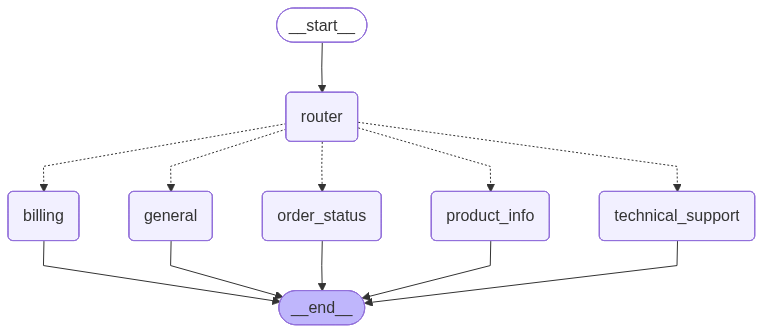

In [9]:
from IPython.display import Image

graph = create_routing_graph(routing_method="llm")

Image(graph.get_graph().draw_mermaid_png())


In [10]:
def demo_routing_methods():
    """Demonstrate all routing methods with sample queries"""
    
    test_queries = [
        "Where is my order? I need to track my package",
        "What are the technical specifications of your latest smartphone?",
        "My app keeps crashing when I try to login",
        "I was charged twice for my last order, need a refund",
        "Can you help me with general information about your company?"
    ]
    
    routing_methods = ["llm", "embedding", "rule", "ml"]
    
    print("Customer Service Routing Demonstration")
    print("=" * 50)
    
    for query in test_queries:
        print(f"\nQuery: '{query}'")
        print("-" * 30)
        
        for method in routing_methods:
            # Create graph with specific routing method
            graph = create_routing_graph(method)
            
            # Run the graph
            initial_state = CustomerServiceState(
                messages=[],
                query=query,
                route="",
                response="",
                routing_method=""
            )
            
            result = graph.invoke(initial_state)
            
            print(f"{method.upper():12} -> {result['route']:17} ({result['routing_method']})")
        
        print()

In [ ]:
demo_routing_methods()
    
print("\nExample of running a single routing method:")
print("-" * 40)